In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="tsrd"
 
model_name="EfficientNetb3"
version = "b3"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb3 with 58 classes running on: tsrd
The input image size is:(300, 300)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Dataset size: Train: 4000, Valid: 998, Test: 1000
{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '6': 54, '7': 55, '8': 56, '9': 57}
torch.Size([3, 300, 300])
Datasets loaded and prepared


In [3]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = math.ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*math.ceil(int(channels*width_factor) / 4)
            layers_repeats = math.ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)
model = model.to(device)
from thop import profile
import colorama
from colorama import Fore,Style
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)
#pretesting model for shape
x=torch.randn(64,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, res, res)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.InvertedResidualBlock'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_l

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model requires: 8.2596 GFLOPS

torch.Size([64, 3, 300, 300])
torch.Size([64, 58])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 38, 150, 150]           1,026
       BatchNorm2d-2         [-1, 38, 150, 150]              76
              SiLU-3         [-1, 38, 150, 150]               0
          CNNBlock-4         [-1, 38, 150, 150]               0
            Conv2d-5         [-1, 38, 150, 150]             342
       BatchNorm2d-6         [-1, 38, 150, 150]              76
              SiLU-7         [-1, 38, 150, 150]               0
          CNNBlock-8         [-1, 38, 150, 150]               0
 AdaptiveAvgPool2d-9             [-1, 38, 1, 1]               0
           Conv2d-10              [-1, 9, 1, 1]             351
             SiLU-11              [-1, 9, 1, 1]               0
           Conv2d-12             [-1, 38, 1, 1]             380

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb320211023062819
grandstore_string:
grandstore/tsrd_EfficientNetb320211023062819.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=120,
                    minepoch=30,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 7.415
Training Loss: 1496928.1547 	Validation Loss: 3342.6796

Running epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 29.760
Training Loss: 1170708.5586 	Validation Loss: 2358.6355

Running epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 30.261
Training Loss: 926656.9523 	Validation Loss: 2170.3735

Running epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 45.691
Training Loss: 801296.7703 	Validation Loss: 1715.5192

Running epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 53.507
Training Loss: 693710.9673 	Validation Loss: 1462.9156

Running epoch: 6


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 65.230
Training Loss: 543794.3417 	Validation Loss: 1126.4776

Running epoch: 7


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 77.355
Training Loss: 372106.7199 	Validation Loss: 774.3481

Running epoch: 8


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 89.379
Training Loss: 236732.3020 	Validation Loss: 363.2966

Running epoch: 9


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 92.184
Training Loss: 155214.5681 	Validation Loss: 275.7867

Running epoch: 10


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.393
Training Loss: 96417.0816 	Validation Loss: 149.7330

Running epoch: 11


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 96.894
Training Loss: 66459.2280 	Validation Loss: 123.0167

Running epoch: 12


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.094
Training Loss: 41358.2487 	Validation Loss: 132.1131

Running epoch: 13


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 97.996
Training Loss: 50249.0377 	Validation Loss: 98.2332

Running epoch: 14


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 27113.2400 	Validation Loss: 65.1975

Running epoch: 15


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 17627.9404 	Validation Loss: 67.6707

Running epoch: 16


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 19993.5217 	Validation Loss: 78.2846

Running epoch: 17


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.196
Training Loss: 12986.9361 	Validation Loss: 111.0818

Running epoch: 18


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.896
Training Loss: 40946.9548 	Validation Loss: 89.6998

Running epoch: 19


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.397
Training Loss: 30186.8256 	Validation Loss: 91.5357

Running epoch: 20


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.697
Training Loss: 20929.1599 	Validation Loss: 84.3277

Running epoch: 21


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.898
Training Loss: 10373.9916 	Validation Loss: 72.7449

Running epoch: 22


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.798
Training Loss: 7548.4372 	Validation Loss: 62.3253

Running epoch: 23


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.397
Training Loss: 8504.6112 	Validation Loss: 88.7159

Running epoch: 24


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.796
Training Loss: 15953.3021 	Validation Loss: 103.8058

Running epoch: 25


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.697
Training Loss: 15477.7043 	Validation Loss: 81.2831

Running epoch: 26


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.996
Training Loss: 10861.7189 	Validation Loss: 98.3821

Running epoch: 27


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.297
Training Loss: 17744.3875 	Validation Loss: 100.4809

Running epoch: 28


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 7426.5508 	Validation Loss: 76.9444

Running epoch: 29


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.196
Training Loss: 11691.1545 	Validation Loss: 90.8275

Running epoch: 30


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.996
Training Loss: 32015.6719 	Validation Loss: 87.9721

Running epoch: 31


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.497
Training Loss: 9644.3326 	Validation Loss: 82.5087

Running epoch: 32


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.397
Training Loss: 9517.4954 	Validation Loss: 80.0994

Running epoch: 33


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.996
Training Loss: 10460.2802 	Validation Loss: 107.6875

Running epoch: 34


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 98.898
Training Loss: 5218.1978 	Validation Loss: 67.1093

Running epoch: 35


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 3631.6364 	Validation Loss: 64.0527

Running epoch: 36


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.796
Training Loss: 8606.2552 	Validation Loss: 119.0948

Running epoch: 37


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.493
Training Loss: 10864.7324 	Validation Loss: 169.9448

Running epoch: 38


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 38016.9162 	Validation Loss: 56.9075

Running epoch: 39


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 10845.5756 	Validation Loss: 64.2521

Running epoch: 40


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 4725.4867 	Validation Loss: 59.8476

Running epoch: 41


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 3491.7393 	Validation Loss: 79.1133

Running epoch: 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 5137.5509 	Validation Loss: 64.4417

Running epoch: 43


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 4874.2940 	Validation Loss: 69.5183

Running epoch: 44


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 4823.0566 	Validation Loss: 68.6905

Running epoch: 45


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.597
Training Loss: 2196.2715 	Validation Loss: 112.0320

Running epoch: 46


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 97.495
Training Loss: 11607.4012 	Validation Loss: 126.8463

Running epoch: 47


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.497
Training Loss: 27293.1965 	Validation Loss: 79.0275

Running epoch: 48


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 13747.7521 	Validation Loss: 62.2564

Running epoch: 49


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 16217.6860 	Validation Loss: 58.7930

Running epoch: 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 2410.3182 	Validation Loss: 64.8900

Running epoch: 51


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.697
Training Loss: 1396.0395 	Validation Loss: 63.5388

Running epoch: 52


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.497
Training Loss: 10000.7264 	Validation Loss: 99.8624

Running epoch: 53


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 15115.6592 	Validation Loss: 62.9046

Running epoch: 54


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 4309.9015 	Validation Loss: 45.2337

Running epoch: 55


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 1302.2996 	Validation Loss: 56.1759

Running epoch: 56


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 2236.3630 	Validation Loss: 45.2022

Running epoch: 57


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 2419.8847 	Validation Loss: 46.7500

Running epoch: 58


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 489.3639 	Validation Loss: 54.1410

Running epoch: 59


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 1330.6468 	Validation Loss: 51.3199

Running epoch: 60


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 652.9151 	Validation Loss: 55.6501

Running epoch: 61


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 94.990
Training Loss: 7334.3646 	Validation Loss: 260.8873

Running epoch: 62


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 32760.9540 	Validation Loss: 61.2920

Running epoch: 63


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.898
Training Loss: 6661.1045 	Validation Loss: 67.4752

Running epoch: 64


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 5568.5386 	Validation Loss: 62.6003

Running epoch: 65


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 2856.2052 	Validation Loss: 45.9020

Running epoch: 66


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 2388.8708 	Validation Loss: 49.7799

Running epoch: 67


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1587.6678 	Validation Loss: 58.7086

Running epoch: 68


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 601.5044 	Validation Loss: 62.1187

Running epoch: 69


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 943.6772 	Validation Loss: 57.0993

Running epoch: 70


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 501.4453 	Validation Loss: 62.4243

Running epoch: 71


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 96.994
Training Loss: 11256.9754 	Validation Loss: 140.3330

Running epoch: 72


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 26064.6373 	Validation Loss: 70.8776

Running epoch: 73


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 8958.7521 	Validation Loss: 46.7447

Running epoch: 74


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 1297.4500 	Validation Loss: 52.1506

Running epoch: 75


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 1442.4301 	Validation Loss: 50.3566

Running epoch: 76


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 254.3899 	Validation Loss: 49.3607

Running epoch: 77


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 530.7104 	Validation Loss: 50.7884

Running epoch: 78


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 580.4884 	Validation Loss: 49.7593

Running epoch: 79


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 731.7466 	Validation Loss: 47.7970

Running epoch: 80


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 741.4683 	Validation Loss: 50.3092

Running epoch: 81


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 492.9167 	Validation Loss: 48.8777

Running epoch: 82


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 242.8548 	Validation Loss: 55.4507

Running epoch: 83


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.699
Training Loss: 1431.7556 	Validation Loss: 48.6391

Running epoch: 84


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.297
Training Loss: 1052.0624 	Validation Loss: 100.9843

Running epoch: 85


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 38693.3396 	Validation Loss: 56.9525

Running epoch: 86


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.898
Training Loss: 6748.2017 	Validation Loss: 89.1747

Running epoch: 87


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 6109.0010 	Validation Loss: 62.9426

Running epoch: 88


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 5150.0521 	Validation Loss: 59.7209

Running epoch: 89


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.898
Training Loss: 746.7725 	Validation Loss: 64.8639

Running epoch: 90


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 4093.0018 	Validation Loss: 54.4756

Running epoch: 91


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 2652.2545 	Validation Loss: 64.4449

Running epoch: 92


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 473.6712 	Validation Loss: 61.1716

Running epoch: 93


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1321.5971 	Validation Loss: 56.0846

Running epoch: 94


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 3116.1113 	Validation Loss: 77.8877

Running epoch: 95


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 7115.2436 	Validation Loss: 63.1448

Running epoch: 96


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 9715.5263 	Validation Loss: 57.0411

Running epoch: 97


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 993.6595 	Validation Loss: 55.3272

Running epoch: 98


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 9629.9346 	Validation Loss: 64.6187

Running epoch: 99


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 2693.8190 	Validation Loss: 70.5588

Running epoch: 100


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1078.0834 	Validation Loss: 64.8733

Running epoch: 101


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1088.6255 	Validation Loss: 63.5469

Running epoch: 102


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 1771.8296 	Validation Loss: 78.3096

Running epoch: 103


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 907.5205 	Validation Loss: 64.4071

Running epoch: 104


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.998
Training Loss: 1126.3519 	Validation Loss: 70.3160

Running epoch: 105


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 976.6320 	Validation Loss: 69.0836

Running epoch: 106


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.098
Training Loss: 477.0525 	Validation Loss: 70.8869

Running epoch: 107


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 157.7441 	Validation Loss: 61.0445

Running epoch: 108


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 930.9845 	Validation Loss: 64.5824

Running epoch: 109


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 736.7981 	Validation Loss: 58.4625

Running epoch: 110


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.198
Training Loss: 270.7371 	Validation Loss: 65.2914

Running epoch: 111


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 690.2652 	Validation Loss: 65.2801

Running epoch: 112


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.299
Training Loss: 1509.2526 	Validation Loss: 75.5864

Running epoch: 113


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 98.096
Training Loss: 8815.7560 	Validation Loss: 121.8787

Running epoch: 114


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 34740.5369 	Validation Loss: 48.7213

Running epoch: 115


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1041.8049 	Validation Loss: 43.4479

Running epoch: 116


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 2291.4041 	Validation Loss: 43.5606

Running epoch: 117


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 664.9709 	Validation Loss: 38.7494

Running epoch: 118


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.499
Training Loss: 1592.5488 	Validation Loss: 40.9200

Running epoch: 119


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 99.399
Training Loss: 706.9007 	Validation Loss: 55.5792

Running epoch: 120


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 99.599
Training Loss: 871.0606 	Validation Loss: 53.7166



Total Run 120 epoch(s)
Accuracy MIN: 7.414829659318637 / MAX: 99.6993987975952

Top 5 performing epochs:
#1 epoch 83	||train_acc 99.699%	||test 99.7%
#2 epoch 81	||train_acc 99.699%	||test 99.7%
#3 epoch 80	||train_acc 99.699%	||test 99.7%
#4 epoch 79	||train_acc 99.699%	||test 99.7%
#5 epoch 78	||train_acc 99.699%	||test 99.7%

Last epoch:
epoch 120	||train_acc 99.60%	||test 99.5%

The model has parameters: 40722906


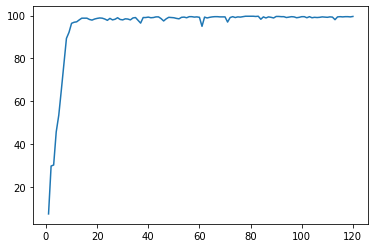

In [10]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.3f}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [11]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/tsrd_EfficientNetb320211023062819.pkl
